In [1]:
# Import the dependencies
import os
from dotenv import load_dotenv
from pymongo import MongoClient
import pandas as pd
import numpy as np
from functools import reduce
import time
import timeit

from joblib import Parallel, delayed
from scipy.stats import entropy

from sklearn_extra.cluster import KMedoids
from sklearn.cluster import HDBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import davies_bouldin_score, mutual_info_score, silhouette_samples, silhouette_score
from sklearn.preprocessing import MaxAbsScaler

import hvplot.pandas
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import plotly.express as px
from ydata_profiling import ProfileReport

# Suppress YData profile report generation warnings - no actual problems to resolve.
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [2]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get references to the data collections
data1 = db['ELR_Data']
data2 = db['Encoded_Gov_Data']
data3 = db['Encoded_SSS_Data']

In [3]:
# Create a dataframe from the ELR_Data collection
combined_df = pd.DataFrame(list(data1.find()))

# Create a dataframe from the Gov_Clusters collection
gc_df = pd.DataFrame(list(data2.find()))

# Create a dataframe from the SSS_Cluster collection
sc_df = pd.DataFrame(list(data3.find()))

In [4]:
# Create a copy of the original combined dataframe
ori_df = combined_df.copy()

# Drop the database id data and refresh the index
combined_df = combined_df.drop(['_id', 'Country', 'Year'], axis=1)
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.set_index('Country_Year')
combined_df = combined_df.drop(['Gov Type', 'SSS Type'], axis=1)
# Sort by index
combined_df = combined_df.sort_index()

gc_df = gc_df.drop(['_id'], axis=1)
gc_df = gc_df.reset_index(drop=True)
gc_df = gc_df.set_index('Country_Year')
# Sort by index
gc_df = gc_df.sort_index()

sc_df = sc_df.drop(['_id'], axis=1)
sc_df = sc_df.reset_index(drop=True)
# Sort by index
sc_df = sc_df.sort_index()

In [5]:
# Collect the column labels so they can be reapplied after data scaling
numeric_col_names = combined_df.columns.tolist()

# Standardize the data with MaxAbsScaler().
scaler = MaxAbsScaler()
scaled_nda = scaler.fit_transform(combined_df)

# Convert the scaled-encoded data back to a DataFrame (nda = Numpy Data Array)
scaled_df = pd.DataFrame(scaled_nda, index=combined_df.index)

# Apply the column labels to ensure the data is properly identified
scaled_df = scaled_df.set_axis(numeric_col_names, axis=1)
scaled_df = scaled_df.sort_index()

In [6]:
scaled_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),Capital HE (% GDP),Domestic General Gov HE (% GDP),Domestic General Gov HE per capita (PPP Intl $),Domestic Private HE per capita (PPP Intl $),GDP growth per capita %,GDP per capita (PPP Intl $),Daily Caloric Supply,Tobacco use (% adults),Alcohol Use per capita (liters)
Country_Year,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.079641,0.015622,0.661004,0.510949,0.320488
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.196233,0.011698,0.662033,0.510949,0.320488
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,-0.047142,0.011172,0.683140,0.510949,0.320488
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.072821,0.012607,0.719434,0.510949,0.320488
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,0.001596,0.204715,0.015604,0.020498,0.063851,0.014031,0.740541,0.510949,0.320488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,0.053123,0.118002,0.009254,0.011541,0.020710,0.015055,0.491120,0.176642,0.227805
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,0.469491,0.038642,0.002836,0.005581,-0.058210,0.014072,0.491120,0.176642,0.227805
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,0.036520,0.056014,0.003928,0.004664,-0.068838,0.012877,0.491120,0.170803,0.227805


In [7]:
# Merge the cluster DataFrames with the primary data.
frames = [scaled_df, gc_df, sc_df]
merge_frames_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

complete_df = merge_frames_df.copy().reset_index(drop=True)
complete_df = complete_df.set_index('Country_Year')
complete_df = complete_df.sort_index()

In [8]:
complete_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,0.4,0.458333,0.006559,0.002319,0.001758,0.855510,0.162691,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,0.4,0.458333,0.006519,0.002305,0.001829,0.858247,0.172303,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,0.4,0.458333,0.006480,0.002291,0.001840,0.862188,0.189035,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,0.4,0.458333,0.006440,0.002277,0.001808,0.864808,0.162335,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,0.4,0.458333,0.006401,0.002263,0.001780,0.867054,0.152486,1.000000,0.291190,0.019038,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,0.2,0.202778,0.002128,0.010621,0.007380,0.718313,0.023852,0.454003,0.228792,0.015389,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,0.2,0.202778,0.002170,0.010835,0.007563,0.716886,0.023140,0.466821,0.179282,0.011286,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,0.2,0.202778,0.002215,0.011057,0.007685,0.714921,0.022428,0.527477,0.167810,0.010094,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Prepare the visualization dataframe
frames = [combined_df, gc_df, sc_df]
merge_df = reduce(lambda left,right: pd.merge(left,right,how='left',on='Country_Year'),frames)

In [10]:
viz_df = merge_df.copy().reset_index(drop=True)
viz_df = viz_df.set_index('Country_Year')
viz_df = viz_df.sort_index()

In [11]:
viz_df

,SSS Depth,Avg Rainfall (mm/yr),Pop Density (#/sq km),Total Population (M),Total Labor Force (M),LEx years,Doctors (#/10k pop),Electricity Access (% Pop),Current HE (% GDP),Current HE per capita (PPP Intl $),...,Universal (birth grant),Universal (cash maternity benefits),Universal (cash parental grants),Universal (paid parental leave),Universal (parental benefits),Universal (pregnancy grant),Universal (prenatal care grant),Universal medical benefits,Voluntary community-based social insurance system (medical benefits),Voluntary pension scheme
Country_Year,,,,,,,,,,,,,,,,,,,,,
Albania_1990,2,1485.0,119.946788,3.286542,1.374478,73.144,13.71,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1991,2,1485.0,119.225912,3.266790,1.429833,73.378,14.52,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1992,2,1485.0,118.505073,3.247039,1.438342,73.715,15.93,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1993,2,1485.0,117.784197,3.227287,1.413557,73.939,13.68,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
Albania_1994,2,1485.0,117.063358,3.207536,1.391914,74.131,12.85,100.000000,5.944186,222.786533,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zimbabwe_2018,1,657.0,38.909614,15.052184,5.770226,61.414,2.01,45.400288,4.670418,180.091128,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2019,1,657.0,39.691374,15.354608,5.912685,61.292,1.95,46.682095,3.659765,132.068691,...,0,0,0,0,0,0,0,0,0,0
Zimbabwe_2020,1,657.0,40.505793,15.669666,6.008633,61.124,1.89,52.747667,3.425581,118.127063,...,0,0,0,0,0,0,0,0,0,0


### Determine number of components for PCA ###

In [12]:
# Function to compute Minimum Average Partial (MAP) Criterion using Velicer's MAP test with parallel execution
def calculate_map_parallel(data, max_components, n_jobs=-1):
    def compute_partial_corr(num_components):
        pca_model = PCA(n_components=num_components)
        pca_data = pca_model.fit_transform(data)
        
        # Calculate the partial correlation matrix
        partial_corr_matrix = np.corrcoef(pca_data, rowvar=False)
        np.fill_diagonal(partial_corr_matrix, np.nan)
        
        # Calculate the average squared partial correlation
        avg_sq_partial_corr = np.nanmean(partial_corr_matrix ** 2)
        return avg_sq_partial_corr

    parallel = Parallel(n_jobs=n_jobs)
    map_values = parallel(delayed(compute_partial_corr)(i) for i in range(2, max_components + 1))

    components_to_retain_map = np.argmin(map_values) + 2  # Adding 2 because range starts from 2
    return components_to_retain_map, map_values

In [13]:
# Function to compute the viable PCA components for a given dataset
def compute_pca(input_data):  
    # Fit PCA on actual data
    pca_actual = PCA(svd_solver='full').fit(input_data)

    print(f"Total number of data features: {pca_actual.n_features_in_}")
    print(f"Total number of data samples: {pca_actual.n_samples_}")
    print(f"PCA Estimated Number of components: {pca_actual.n_components_}")
    
    cumulative_variance_ratio = np.cumsum(pca_actual.explained_variance_ratio_)
    plt.plot(cumulative_variance_ratio)
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    plt.axhline(y=0.95, color='r', linestyle='-')
    plt.show()

Total number of data features: 107
Total number of data samples: 6105
PCA Estimated Number of components: 107


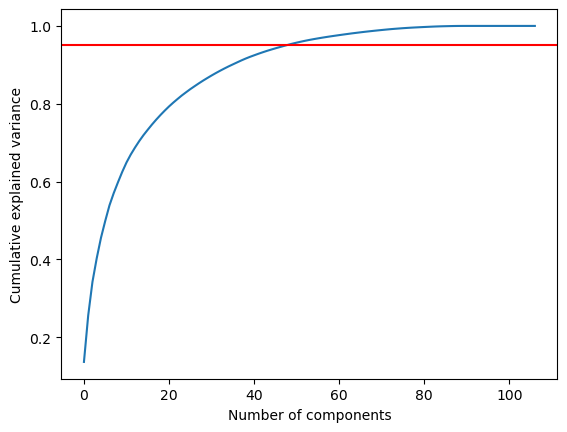

In [14]:
# Determine the number of appropriate components for PCA (scaled (combined) data)
compute_pca(complete_df)

In [15]:
# Function to perform PCA for the provided data
def perform_pca(input_data, name, n_comp):
    pca = PCA(n_components=n_comp, random_state=42)
    pca_out = pca.fit_transform(input_data)

    # Create a DataFrame with the principal components.
    columnz =[]

    for i in range(1,n_comp+1):
        columnz.append(name + '_pc'+str(i))
    
    out_df = pd.DataFrame(data=pca_out, columns=columnz)

    out_df['Country_Year'] = ori_df['Country_Year']
    out_df = out_df.reset_index(drop=True)
    out_df = out_df.set_index('Country_Year')
    return out_df

#### Use the PCA data to guide component number selection

In [16]:
# Perform PCA on the complete_df.
complete_pca_df = perform_pca(complete_df, 'Complete', 45)

### Determine the number of (KMedoids) clusters for this complete dataset

In [17]:
# Use KMedoids and compute Davies-Bouldin scores, elbow curve, and silhouette scores to determine the optimal number of clusters.
def compute_kmedoids_cluster_metrics(data_in, n_clusters):
    """
    Function to compute cluster metrics for a given number of clusters.
    This function will be called in parallel.
    """
    # Initialize the clusterer with n_clusters value and random state for reproducibility
    clusterer = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    cluster_labels = clusterer.fit_predict(data_in)
    
    # Compute the scores for various metrics
    davies_bouldin = davies_bouldin_score(data_in, cluster_labels)
    inertia = clusterer.inertia_
    silhouette_avg = silhouette_score(data_in, cluster_labels)
    
    return n_clusters, davies_bouldin, inertia, silhouette_avg
    
def compute_clusters_parallel(data_in, max_clusters, n_jobs=-1):
    # Parallel computation of the cluster metrics for each number of clusters from 2 to max_clusters
    parallel = Parallel(n_jobs=n_jobs)
    kmedoids_cluster_metrics_list = parallel(delayed(compute_kmedoids_cluster_metrics)(data_in, n_clusters)
                                    for n_clusters in range(2, max_clusters + 1))

    # Creating a DataFrame to store the clustering metrics
    kmedoids_cluster_metrics_df = pd.DataFrame(kmedoids_cluster_metrics_list,
                                      columns=['Num_Clusters', 'Davies_Bouldin', 'Inertia', 'Silhouette_Avg'])

    return kmedoids_cluster_metrics_df

In [18]:
### Compute KMedoids clusters and metrics for the complete dataset

In [19]:
# Start timing
start = time.perf_counter()

# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe
non_pca_kmedoid_cluster_scores_df = compute_clusters_parallel(data_in=complete_df, max_clusters=55, n_jobs=-1)

# Stop timing
stop = time.perf_counter()

print(f"KMedoids Clustering Execution in {stop - start:0.4f} seconds")

KMedoids Clustering Execution in 15.3461 seconds


In [20]:
### Compute KMedoids clusters and metrics for the PCA dataset

In [21]:
# Start timing
pca_kmedoid_cluster_start = time.perf_counter()

# Create a DataFrame of the results for further analysis downstream - Compute clusters for the complete dataframe with PCA
pca_kmedoid_cluster_scores_df= compute_clusters_parallel(data_in=complete_pca_df, max_clusters=55, n_jobs=-1)

# Stop timing
pca_kmedoid_cluster_stop = time.perf_counter()

print(f"PCA KMedoids Clustering Execution in {pca_kmedoid_cluster_stop - pca_kmedoid_cluster_start:0.4f} seconds")

PCA KMedoids Clustering Execution in 11.7178 seconds


In [22]:
pca_kmedoid_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Davies_Bouldin')

:Scatter   [Num_Clusters]   (Davies_Bouldin)

In [23]:
pca_kmedoid_cluster_scores_df.hvplot.scatter(x='Num_Clusters', y='Silhouette_Avg')

:Scatter   [Num_Clusters]   (Silhouette_Avg)

In [24]:
# define the model
cluster_model = KMedoids(n_clusters=2, init='k-medoids++', random_state=42)

# Fit the model and predict labels
cluster_model.fit_predict(complete_pca_df)

# Add the predicted class columns to the visualization dataset
viz_df['Cluster Label'] = cluster_model.labels_

## Principal Feature Analysis ##

#### Define functions to select dataset features that provide relevant information for clustering. 
##### Only important features are used to compute clusters from the complete (non-pca) dataset.

In [25]:
# Define the generic prefilter function
def prefilter_features(df, threshold=0.008):
    """
    Prefilter features with low variance.
    """
    # Threshold can be set according to domain knowledge or exploratory analysis
    selector = VarianceThreshold(threshold)
    selector.fit(df)
    
    # Return the dataframe with selected features
    return df[df.columns[selector.get_support(indices=True)]]  

In [26]:
# Calculate generic entropy
def calculate_entropy(labels):
    value, counts = np.unique(labels, return_counts=True)
    return entropy(counts, base=None) # Use natural log base

In [27]:
# Generic Silhouette score adjusted by entropy
def clustering_score(df, n_clusters, algorithm):
    if algorithm == 'kmedoids':
        model = KMedoids(n_clusters=n_clusters, init='k-medoids++', random_state=42)
    else:
        model = HDBSCAN(min_cluster_size=5, min_samples=None, cluster_selection_method='eom', n_jobs=-1)

    labels = model.fit_predict(df)
    noise = labels == -1  # Mask for noise points, valid only for HDBSCAN

    if noise.any():  # If there is noise, filter it out for silhouette calculation
        silhouette_avg = silhouette_score(df[~noise], labels[~noise]) if np.unique(labels[~noise]).size > 1 else 0
    else:
        silhouette_avg = silhouette_score(df, labels) if np.unique(labels).size > 1 else 0

    if silhouette_avg == 0:
        return 0  # Return early if silhouette score is 0

    entropy_score = calculate_entropy(labels[~noise] if noise.any() else labels)
    entropy_score = max(entropy_score, 1e-9)  # Prevent division by zero or very low entropy values

    return silhouette_avg / entropy_score

In [28]:
# Generic function to evaluate clusters with a set of features removed
def evaluate_feature_set(df, features_to_exclude, n_clusters, algorithm):
    features_to_try = df.columns.difference(features_to_exclude)
    if len(features_to_try) == 0:
        return -1, [], n_clusters
    score = clustering_score(df[features_to_try], n_clusters, algorithm)
    return score, features_to_try, n_clusters

In [44]:
# Principal Feature Analysis with parallel processing
def select_features_and_cluster_parallel(df, algorithm, max_clusters=60, n_jobs=-1):
    # Prefilter features based on variance
    df_prefiltered = prefilter_features(df)
    
    # Calculate initial score for two clusters with all features
    initial_score, _, _ = evaluate_feature_set(df, [], 2, algorithm)

    # Convert to list for indexing
    features_list = df_prefiltered.columns.tolist()
    
    num_features = len(features_list)
    selected_features = list(features_list)
    current_score = initial_score
    best_score = initial_score
    best_features = list(features_list)
    best_k = 1
    improvement = True

    # Parallel computation setup
    parallel = Parallel(n_jobs=n_jobs)

    while improvement and len(selected_features) > 1:
        improvement = False

        if algorithm == 'kmedoids':
            # This will generate a list of (score, feature_subset, k) for all combinations
            scores_features_k = parallel(delayed(evaluate_feature_set)(df_prefiltered, [f], k, algorithm)
                                         for f in selected_features for k in range(2, max_clusters + 1))
            # Check if the list is not empty to avoid ValueError
            if not scores_features_k:
                break
        else:
            scores_features_k = parallel(delayed(evaluate_feature_set)(df_prefiltered, [f], 2, 'hdbscan')
                                     for f in selected_features)
                    
        # Find the best score, corresponding feature set and k
        best_score, best_features, best_k = max(scores_features_k, key=lambda item: (item[0], -len(item[1])))

        if best_score > current_score:
            current_score = best_score
            improvement = True
        
            # Remove one feature (with the worst score) at a time for the next round
            scores_features = sorted(scores_features_k, key=lambda item: item[0])
            if scores_features:  # Check if there are features scored
                lowest_score, worst_features, _ = scores_features[0]
                if worst_features[0] in selected_features:
                    selected_features.remove(worst_features[0])  # Remove worst feature for the next iteration

        final_score = best_score - initial_score

    # Output results
    print(f'Total score improvement = best score:{best_score} - initial score:{initial_score} = Improvement:{final_score}')
    print("Best number of clusters:", best_k)
    print("Best subset of features by index:", best_features)
    return best_k, best_features 

In [30]:
# Define a function that generates a profile report and saves it to a file
def generate_report(df, config_file, output_file):
    profile = ProfileReport(df, config_file=config_file)
    profile.to_file(output_file)
    print(f"Report {output_file} generated.")

### Perform PFA

#### KMedoids

In [45]:
# Start timing
start = time.perf_counter()

# Run the experiment using the complete (non-pca) dataframe
best_k, best_kmedoid_features = select_features_and_cluster_parallel(complete_df, 'kmedoids')

# Stop timing
stop = time.perf_counter()

print(f" ^^^ PFA KMedoids Clustering Execution in {stop - start:0.4f} seconds ^^^ ")

Total score improvement = best score:0.13202281325847776 - initial score:0.12463438892628767 = Improvement:0.0073884243321900855
Best number of clusters: 2
Best subset of features by index: Index(['Alcohol Use per capita (liters)', 'Avg Rainfall (mm/yr)',
       'Capital HE (% GDP)', 'Current HE (% GDP)',
       'Current HE per capita (PPP Intl $)', 'Daily Caloric Supply',
       'Doctors (#/10k pop)', 'Domestic General Gov HE (% GDP)',
       'Domestic General Gov HE per capita (PPP Intl $)',
       'Electricity Access (% Pop)', 'Employer-liability system',
       'Employer-liability system (cash benefits)',
       'Employer-liability system (cash maternity benefits)',
       'Employer-liability system (cash medical benefits)',
       'Employer-liability system (cash sickness benefits)',
       'Employer-liability system (maternity benefits)',
       'Employer-liability system (medical benefits)',
       'Employer-liability system (paternity benefits)',
       'Employer-liability syst

In [36]:
# Use the selected features for the final KMedoids clustering
kmedoids_reduced_features_df = complete_df[best_kmedoid_features].copy()

# Perform clustering on the final set of features
kmedoids_final_model = KMedoids(n_clusters=best_k, init='k-medoids++', random_state=42)
kmedoids_final_labels = kmedoids_final_model.fit_predict(kmedoids_reduced_features_df)
kmedoids_final_cluster_centers = kmedoids_final_model.cluster_centers_

# Create the dataframes for visualization
kmedoids_final_reduced_features_df = viz_df[best_kmedoid_features].copy()
kmedoids_final_reduced_features_df['KMedoids Clusters'] = kmedoids_final_labels

kmedoids_final_complete_features_df = viz_df.copy()
kmedoids_final_complete_features_df['KMedoids Clusters'] = kmedoids_final_labels

In [38]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the KMedoids feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': kmedoids_final_reduced_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Reduced-Features_Report.html'
    },
    {
        'df': kmedoids_final_complete_features_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'KMedoids_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final KMedoids Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

 ^^^ Final KMedoids Clustering Report building in 162.9844 seconds ^^^ 


#### HDBSCAN

In [39]:
# Start timing
start = time.perf_counter()

# Run the experiment using the complete (non-pca) dataframe
not_used, best_hdbscan_features = select_features_and_cluster_parallel(complete_df, 'hdbscan')

# Stop timing
stop = time.perf_counter()

print(f" ^^^ PFA HDBSCAN Clustering Execution in {stop - start:0.4f} seconds ^^^ ")

Total score improvement = best score:0.07428326066252285 - initial score:0.08104411152141956 = Improvement:-0.0067608508588967164
Best number of clusters: 2
Best subset of features by index: Index(['Alcohol Use per capita (liters)', 'Avg Rainfall (mm/yr)',
       'Current HE (% GDP)', 'Current HE per capita (PPP Intl $)',
       'Daily Caloric Supply', 'Doctors (#/10k pop)',
       'Domestic General Gov HE (% GDP)',
       'Domestic General Gov HE per capita (PPP Intl $)',
       'Electricity Access (% Pop)', 'Employer-liability system',
       'Employer-liability system (cash benefits)',
       'Employer-liability system (cash maternity benefits)',
       'Employer-liability system (cash medical benefits)',
       'Employer-liability system (cash sickness benefits)',
       'Employer-liability system (maternity benefits)',
       'Employer-liability system (medical benefits)',
       'Employer-liability system (paternity benefits)',
       'Employer-liability system (sickness benefits

In [41]:
# Use the selected features for the final HDBSCAN clustering
hdbscan_reduced_features_df = complete_df[best_hdbscan_features].copy()

# Perform clustering on the final set of features
hdbscan_final_model = HDBSCAN(min_cluster_size=25, store_centers='medoid', n_jobs=-1)
hdbscan_final_labels = hdbscan_final_model.fit_predict(hdbscan_reduced_features_df)
hdbscan_final_cluster_centers = hdbscan_final_model.medoids_

# Create the dataframes for visualization
hdbscan_reduced_features_viz_df = viz_df[best_hdbscan_features].copy()
hdbscan_reduced_features_viz_df['HDBSCAN Clusters'] = hdbscan_final_labels

hdbscan_complete_features_viz_df = viz_df.copy()
hdbscan_complete_features_viz_df['HDBSCAN Clusters'] = hdbscan_final_labels

In [43]:
# Start timing
start = time.perf_counter()

# Create YData reports to explore the HDBSCAN feature relationships
# DataFrames and configuration for the reports
reports_info = [
    {
        'df': hdbscan_reduced_features_viz_df,
        'config_file': 'config_ELR.yml',
        'output_file': 'HDBSCAN_Final_Reduced-Features_Report.html'
    },
    {
       'df': hdbscan_complete_features_viz_df,
       'config_file': 'config_ELR.yml',
       'output_file': 'HDBSCAN_Final_Complete-Features_Report.html'
    }
]

# Use joblib to run the report generations in parallel
# n_jobs=-1 uses all available CPUs
Parallel(n_jobs=-1)(delayed(generate_report)(
    info['df'], info['config_file'], info['output_file']) for info in reports_info)

# Stop timing
stop = time.perf_counter()

print(f" ^^^ Final HDBSCAN Clustering Report building in {stop - start:0.4f} seconds ^^^ ")

 ^^^ Final HDBSCAN Clustering Report building in 168.8246 seconds ^^^ 


### Write Results to Project Database ###

In [ ]:
# load the config from the .env file
load_dotenv()
MONGODB_URI = os.environ['MONGODB_URI']

# Connect to the database engine
client = MongoClient(MONGODB_URI)

# connect to the project db
db = client['ExpectLifeRedux']

# get a reference to the data collection
perf_data = db['Supervised_Performance_Data']

In [ ]:
# Create a dictionary to send to MongoDB - Alternate method, not necessary when using PyMongoArrow
perf_dict = performance_df.to_dict('records')
print(perf_dict)

# write the data to the database (alternate method)
perf_data.insert_many(perf_dict)